<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Final-Project-Check-in" data-toc-modified-id="Final-Project-Check-in-1">Final Project Check-in</a></span></li><li><span><a href="#Group-Name" data-toc-modified-id="Group-Name-2">Group Name</a></span></li><li><span><a href="#Student-Names" data-toc-modified-id="Student-Names-3">Student Names</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-4">Load Data</a></span></li><li><span><a href="#Fit-scikit-learn-model" data-toc-modified-id="Fit-scikit-learn-model-5">Fit scikit-learn model</a></span></li><li><span><a href="#Evaluation-Metric" data-toc-modified-id="Evaluation-Metric-6">Evaluation Metric</a></span></li></ul></div>

Final Project Check-in
------

Group Name
-----

### Durian Candy 

Student Names
----

1. Andrew Young
2. Charles Siu
3. Sean Tey
4. Sunny Kwong 

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn import impute
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import median_absolute_error
from rfpimp import *

Load Data
-----

In [2]:
df = pd.read_csv("../data/data_cleaned.csv")
df_copy = df.copy()

# Replace Categorical Missing Value and Do label encoding
cat_col = ['Nationality', 'Club', 'Preferred_Foot', 'Off_Work_Rate', 
           'Def_Work_Rate', 'Real_Face', 'Position', 'Loaned_Out', 'League_Country', 'League_Country']
df[cat_col] = df[cat_col].fillna(value='NA')  # fill na for categorical features
le = preprocessing.LabelEncoder()
for c in cat_col:
    df[c] = le.fit_transform(df[c])

In [3]:
y = df['Value']

In [4]:
X = df.drop('Value',axis=1)

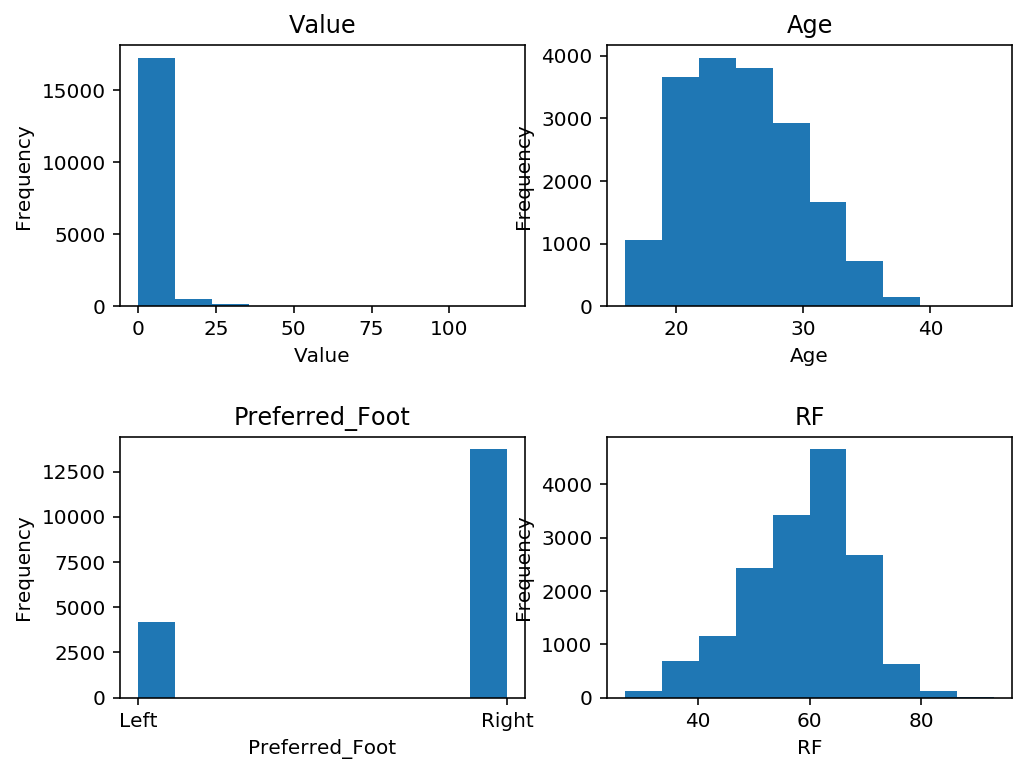

In [26]:
plt_row = 2
plt_col = 2
plt.figure(figsize = (plt_col * 4, plt_row * 3))

for i, col in enumerate(['Value', 'Age', 'Preferred_Foot', 'RF']):
    plt.subplot(plt_row, plt_col, i + 1)
    plt.subplots_adjust(hspace = 0.5)
    x = df_copy[col].dropna(axis=0)
    plt.hist(x)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

Fit scikit-learn model
----

In [7]:
regressor = RandomForestRegressor(n_estimators=30,
                                  min_samples_leaf=1,
                                  random_state=42)

In [8]:
numerical_col =  list(set(df.columns) - set(cat_col))
numerical_col.remove('Value')

In [9]:
def make_pipeline(regressor=None):
    "Create a single pipeline that processing the data and then fits the regressor." 
    
    median_impute = impute.SimpleImputer(strategy='median')

    numerical_names = numerical_col
    
    col_transform = compose.ColumnTransformer([('numerics',median_impute,numerical_names)])

    steps_list = [('col_t',col_transform),('clf',regressor)]

    pipeline = Pipeline(steps=steps_list)
    
    return pipeline

In [10]:
pipeline = make_pipeline(regressor)

In [11]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('col_t',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerics',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='median',
                                                                verbose=0),
                                                  ['LF', 'LM', 'RS',
                                                   'Release_Clause', 'CM', 'RW',
                                                   'Agility', 'RCM', 'CA

Evaluation Metric
----

In [12]:
y_pred = pipeline.predict(X_test)

In [13]:
median_absolute_error(y_true=y_test,y_pred=y_pred)

0.021166666666666722

Feature Importance
---

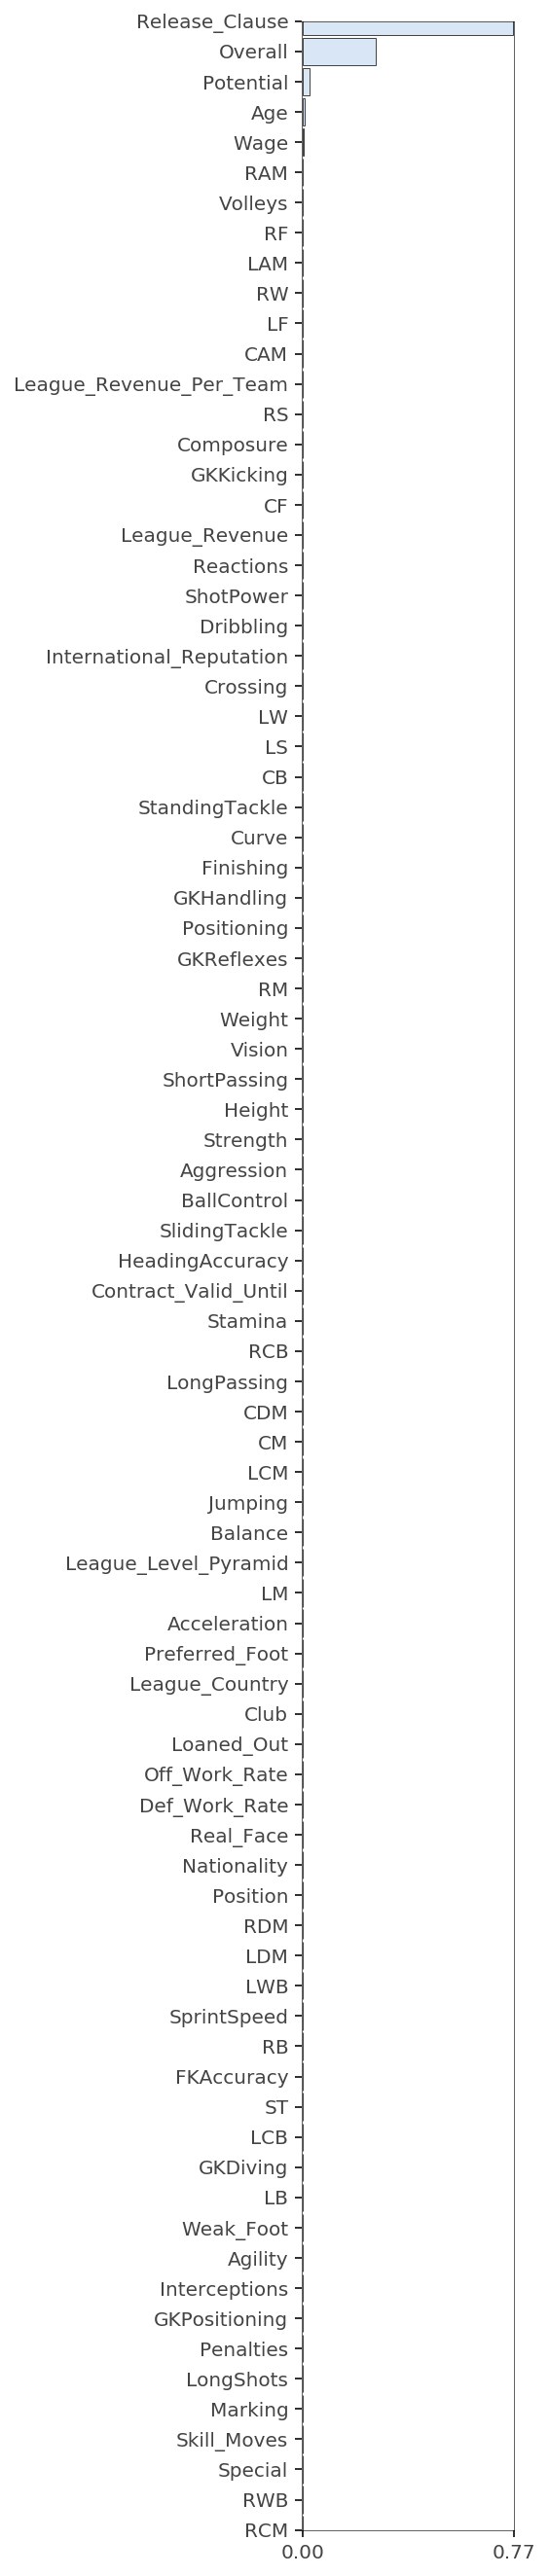

In [14]:
# original feature importance
imp = importances(pipeline, X_test, y_test) # permutation
viz = plot_importances(imp)
viz.view()

In [15]:
X_train.head()

,Age,Nationality,Overall,Potential,Club,Wage,Special,Preferred_Foot,International_Reputation,Weak_Foot,...,GKPositioning,GKReflexes,Release_Clause,League_Country,League_Level_Pyramid,League_Revenue,League_Revenue_Per_Team,Loaned_Out,Off_Work_Rate,Def_Work_Rate
7860,24,55,67,71,76,0.002,1459,2,1.0,3.0,...,6.0,12.0,1.400,17,2.0,276.00,12.5,0,2,0
5256,22,59,70,78,547,0.005,1947,0,1.0,2.0,...,13.0,7.0,3.900,15,2.0,608.00,33.8,0,0,2
14129,25,129,61,64,34,0.006,1530,0,1.0,2.0,...,15.0,15.0,0.577,25,1.0,254.61,18.2,0,2,1
2948,31,6,73,73,429,0.026,1813,2,1.0,3.0,...,16.0,11.0,6.100,19,1.0,509.00,28.0,0,2,2
7540,24,152,67,74,285,0.007,1503,2,1.0,2.0,...,9.0,11.0,2.000,31,1.0,731.00,40.6,0,1,2


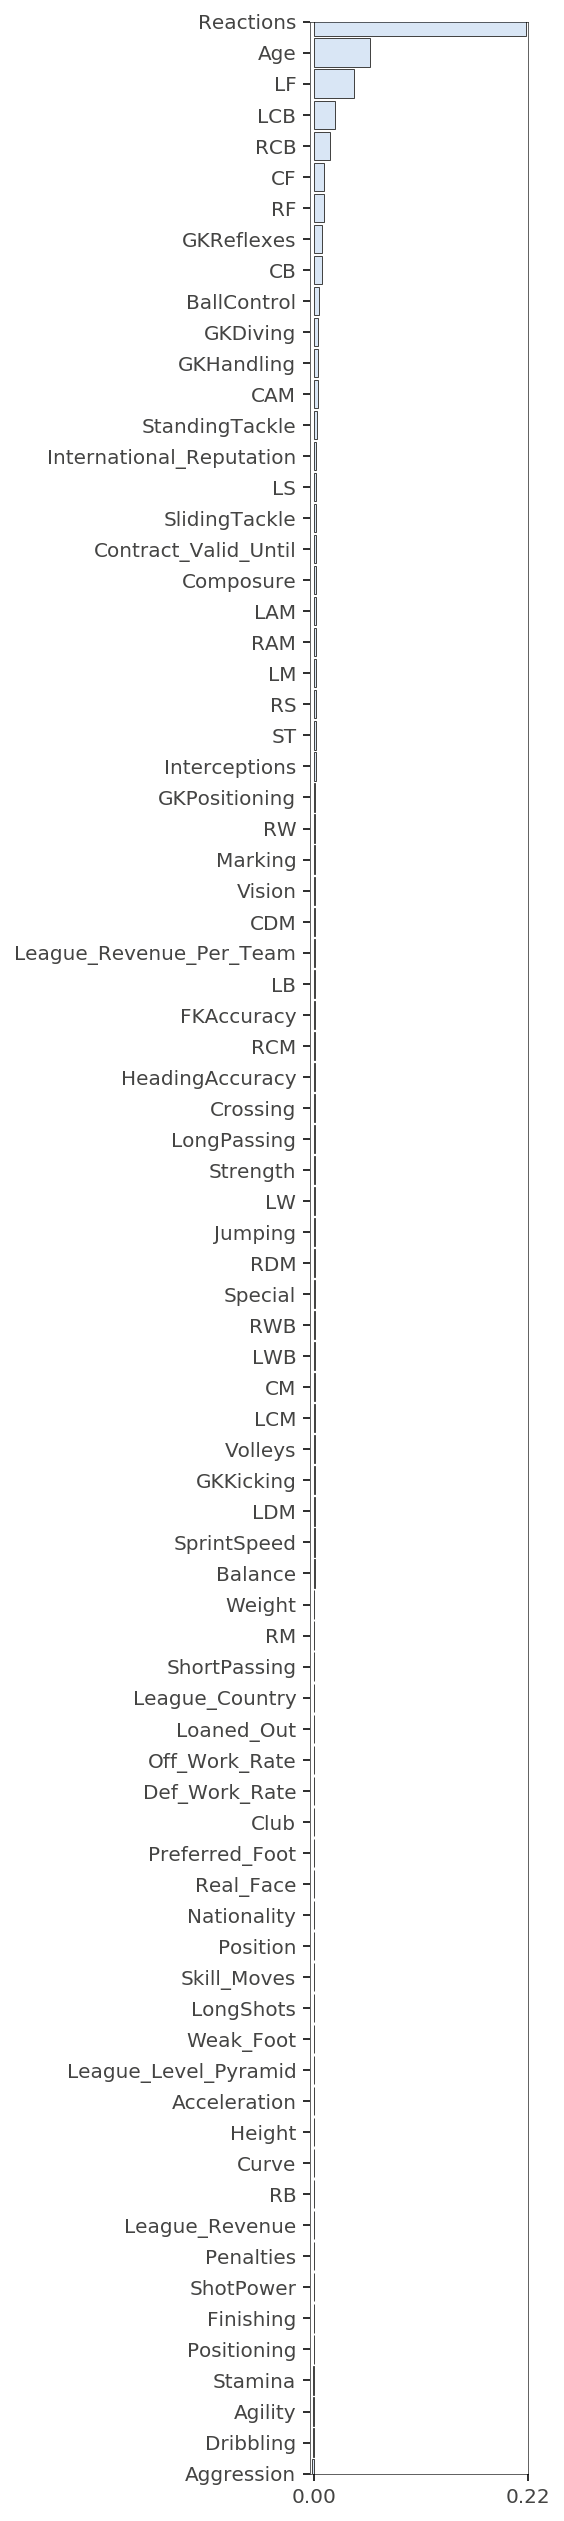

In [16]:
# # feature importance after dropping overall, release clause, and potential

df_drop = df.drop(['Overall', 'Release_Clause', 'Potential', 'Wage'], axis=1)
cat_col = ['Nationality', 'Club', 'Preferred_Foot', 'Off_Work_Rate', 
           'Def_Work_Rate', 'Real_Face', 'Position', 'Loaned_Out', 'League_Country', 'League_Country']

numerical_col = list(set(df_drop.columns) - set(cat_col))
numerical_col.remove('Value')
df_drop[cat_col] = df_drop[cat_col].fillna(value='NA')  # fill na for categorical features
le = preprocessing.LabelEncoder()
for c in cat_col:
    df_drop[c] = le.fit_transform(df_drop[c])
y = df_drop['Value']
X = df_drop.drop('Value',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
pipeline = make_pipeline(regressor)
pipeline.fit(X_train,y_train)
median_absolute_error(y_true=y_test,y_pred=y_pred)

imp = importances(pipeline, X_test, y_test) # permutation
viz = plot_importances(imp)
viz.view()

In [17]:
X_test.head()

,Age,Nationality,Club,Special,Preferred_Foot,International_Reputation,Weak_Foot,Skill_Moves,Real_Face,Position,...,GKKicking,GKPositioning,GKReflexes,League_Country,League_Level_Pyramid,League_Revenue,League_Revenue_Per_Team,Loaned_Out,Off_Work_Rate,Def_Work_Rate
6741,28,46,97,1722,2,1.0,3.0,3.0,1,27,...,14.0,11.0,15.0,12,2.0,842.0,35.10,0,0,2
7851,24,132,319,1843,2,1.0,3.0,3.0,1,21,...,15.0,11.0,13.0,22,1.0,152.0,9.50,0,2,2
8584,19,6,270,1719,2,1.0,3.0,3.0,1,12,...,10.0,10.0,10.0,1,1.0,338.0,17.00,0,2,2
5834,28,30,280,1438,2,1.0,3.0,2.0,1,1,...,6.0,11.0,11.0,7,1.0,945.0,59.00,0,1,0
12812,24,138,457,1383,2,1.0,3.0,2.0,1,1,...,8.0,13.0,7.0,29,1.0,4479.0,223.95,0,2,2
